In [12]:
import pickle
import pandas as pd
import xgboost as xgb
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score

# Load dataset
with open("train_val_test_1.pkl", "rb") as f:
    X_train, X_val, X_test, y_train, y_val, y_test = pickle.load(f)

print("Data successfully loaded!")


Data successfully loaded!


In [13]:
# Convert categorical features to category dtype for XGBoost
categorical_features = ["purpose", "emp_length"]
for col in categorical_features:
    X_train[col] = X_train[col].astype("category")
    X_val[col] = X_val[col].astype("category")
    X_test[col] = X_test[col].astype("category")

print("Categorical processing complete.")


Categorical processing complete.


In [14]:
print(X_train.dtypes.to_string())


acc_open_past_24mths           float64
all_util                       float64
annual_inc                     float64
application_type                 int64
avg_cur_bal                    float64
bc_open_to_buy                 float64
bc_util                        float64
dti                            float64
delinq_2yrs                    float64
emp_length                    category
fico_range_high                float64
fico_range_low                 float64
il_util                        float64
inq_fi                         float64
inq_last_12m                   float64
inq_last_6mths                 float64
installment                    float64
int_rate                       float64
loan_amnt                      float64
max_bal_bc                     float64
mo_sin_old_il_acct             float64
mo_sin_old_rev_tl_op           float64
mo_sin_rcnt_rev_tl_op          float64
mo_sin_rcnt_tl                 float64
mort_acc                       float64
mths_since_rcnt_il       

In [32]:
import xgboost as xgb

# Change different parameters
# Plot cross-validation results

evals_result = {}  # Dictionary to store results
# Initialize XGBoost classifier
xgb_model = xgb.XGBClassifier(
    objective="multi:softmax",  # Multi-class classification
    num_class=len(y_train.unique()),  # Number of unique classes
    tree_method="hist",  # Faster training
    enable_categorical=True,  # Use categorical support
    use_label_encoder=False,
    eval_metric=["mlogloss", "merror", "auc"]  # Move eval_metric here
                            # AUC (Choose other ranking metics)
)

# Train the model with early stopping
xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],  # Validation set
     
    
)

print("Model training complete.")


[0]	validation_0-mlogloss:0.52847	validation_0-merror:0.10865	validation_0-auc:0.78416


/Users/jiaxuanliu/anaconda3/envs/math170/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:06:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[1]	validation_0-mlogloss:0.44011	validation_0-merror:0.10865	validation_0-auc:0.78698
[2]	validation_0-mlogloss:0.38768	validation_0-merror:0.10865	validation_0-auc:0.78853
[3]	validation_0-mlogloss:0.35531	validation_0-merror:0.10865	validation_0-auc:0.78940
[4]	validation_0-mlogloss:0.33472	validation_0-merror:0.10865	validation_0-auc:0.79030
[5]	validation_0-mlogloss:0.32165	validation_0-merror:0.10865	validation_0-auc:0.79096
[6]	validation_0-mlogloss:0.31317	validation_0-merror:0.10865	validation_0-auc:0.79166
[7]	validation_0-mlogloss:0.30767	validation_0-merror:0.10865	validation_0-auc:0.79217
[8]	validation_0-mlogloss:0.30405	validation_0-merror:0.10865	validation_0-auc:0.79279
[9]	validation_0-mlogloss:0.30153	validation_0-merror:0.10865	validation_0-auc:0.79377
[10]	validation_0-mlogloss:0.29982	validation_0-merror:0.10865	validation_0-auc:0.79450
[11]	validation_0-mlogloss:0.29842	validation_0-merror:0.10862	validation_0-auc:0.79589
[12]	validation_0-mlogloss:0.29750	valida

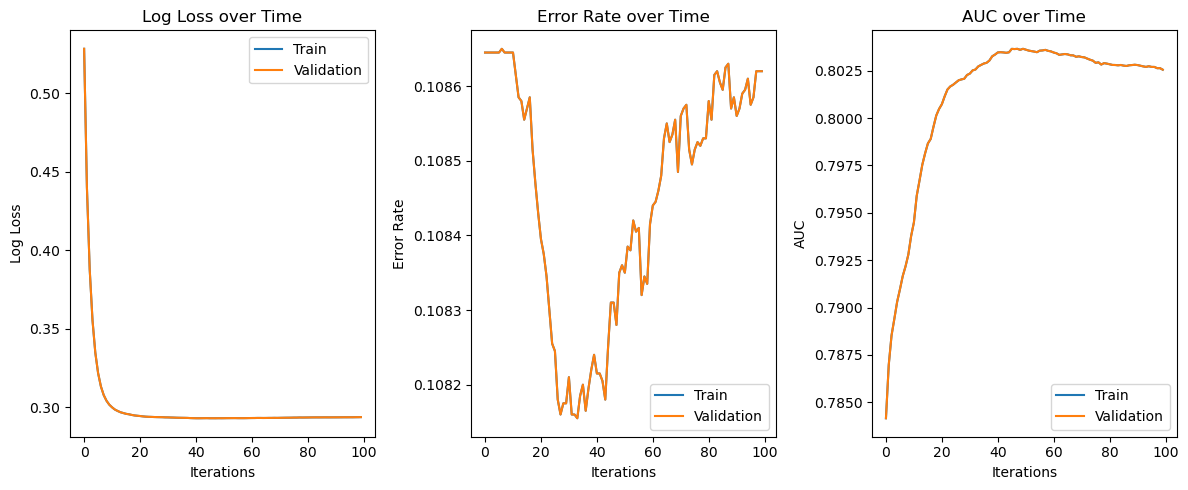

In [34]:
## Plot learning Curve
import matplotlib.pyplot as plt

# Extract evaluation results
results = xgb_model.evals_result()

# Define figure size
plt.figure(figsize=(12, 5))

# Plot Log Loss (mlogloss)
plt.subplot(1, 3, 1)
plt.plot(results["validation_0"]["mlogloss"], label="Train")
plt.plot(results["validation_0"]["mlogloss"], label="Validation")
plt.xlabel("Iterations")
plt.ylabel("Log Loss")
plt.title("Log Loss over Time")
plt.legend()

# Plot Error Rate (merror)
plt.subplot(1, 3, 2)
plt.plot(results["validation_0"]["merror"], label="Train")
plt.plot(results["validation_0"]["merror"], label="Validation")
plt.xlabel("Iterations")
plt.ylabel("Error Rate")
plt.title("Error Rate over Time")
plt.legend()

# Plot AUC (auc)
plt.subplot(1, 3, 3)
plt.plot(results["validation_0"]["auc"], label="Train")
plt.plot(results["validation_0"]["auc"], label="Validation")
plt.xlabel("Iterations")
plt.ylabel("AUC")
plt.title("AUC over Time")
plt.legend()

# Show plots
plt.tight_layout()
plt.show()


## Interpretation

### 1. Log Loss: 
Observation: Both the training and validation log loss decrease rapidly at the beginning and plateau around iteration 30. 

Interpretation: \
The model is converging well, as log loss is decreasing and stabilizing. \
There is no major overfitting since training and validation curves are closely aligned. \
A stable log loss means the model is confident in its predictions.

### 2. Error Rate
Observation: The validation error rate initially drops but then fluctuates after about 40 iterations. 

Interpretation: \
The model is improving in the beginning, but later, the validation error starts to increase slightly. \
This could indicate overfitting, meaning the model is learning patterns in the training data that do not generalize well. \
If error rate keeps increasing, early stopping (already used) is a good safeguard.

### 3. AUC
Observation: The validation AUC increases initially, peaks, and then starts slightly decreasing after ~60 iterations.

Interpretation: \
AUC increasing at first is good—it means the model is improving. \
The drop in AUC after a peak suggests the model is starting to overfit. \
Early stopping is preventing excessive overfitting, but tuning regularization (lambda, alpha) could help.

In [35]:
from sklearn.metrics import accuracy_score, log_loss

# Make predictions on training and test sets
y_train_pred = xgb_model.predict(X_train)  # Predictions on training set
y_test_pred = xgb_model.predict(X_test)  # Predictions on test set

# Compute training and test accuracy
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

# Compute training and test log loss
train_log_loss = log_loss(y_train, xgb_model.predict_proba(X_train))
test_log_loss = log_loss(y_test, xgb_model.predict_proba(X_test))

# Print results
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Training Log Loss: {train_log_loss:.4f}")
print(f"Test Log Loss: {test_log_loss:.4f}")


Training Accuracy: 0.8949
Test Accuracy: 0.8927
Training Log Loss: 0.2735
Test Log Loss: 0.2907


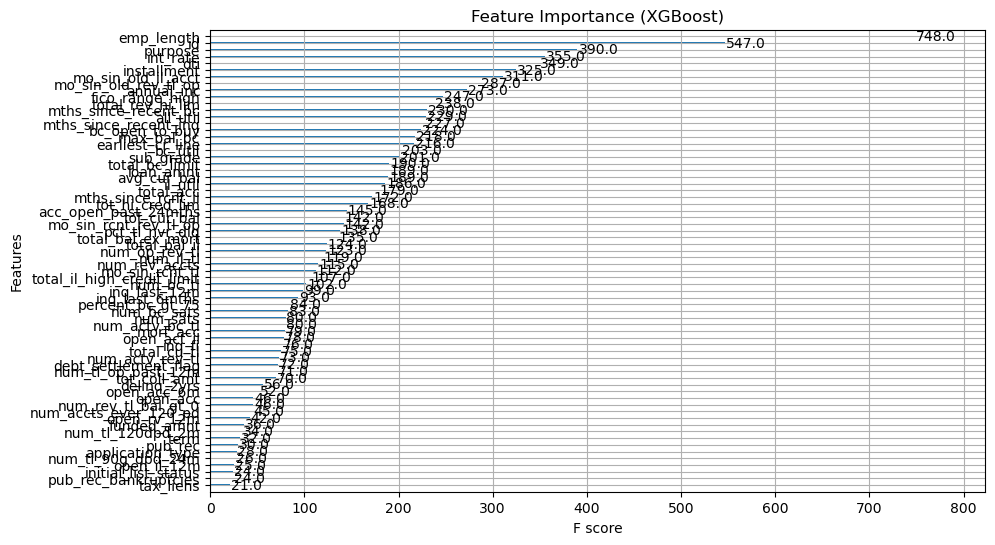

In [36]:
# Feature Importance
import matplotlib.pyplot as plt
import xgboost as xgb

# Plot feature importance
fig, ax = plt.subplots(figsize=(10, 6))
xgb.plot_importance(xgb_model, importance_type="weight", ax=ax)
plt.title("Feature Importance (XGBoost)")
plt.show()

In [37]:
# Get feature importance scores
feature_importance = xgb_model.get_booster().get_score(importance_type="weight")

# Convert to DataFrame for better readability
importance_df = pd.DataFrame(
    feature_importance.items(),
    columns=["Feature", "Importance"]
).sort_values(by="Importance", ascending=False)

print(importance_df.to_string())

                       Feature  Importance
9                   emp_length       748.0
59                          id       547.0
57                     purpose       390.0
16                    int_rate       355.0
7                          dti       349.0
15                 installment       325.0
19          mo_sin_old_il_acct       311.0
20        mo_sin_old_rev_tl_op       287.0
2                   annual_inc       273.0
10             fico_range_high       247.0
60            total_rev_hi_lim       238.0
25        mths_since_recent_bc       230.0
1                     all_util       229.0
26       mths_since_recent_inq       227.0
5               bc_open_to_buy       224.0
18                  max_bal_bc       218.0
61            earliest_cr_line       216.0
6                      bc_util       203.0
53                   sub_grade       201.0
54              total_bc_limit       190.0
4                  avg_cur_bal       189.0
17                   loan_amnt       189.0
11         